In [1]:
#%% Library
import os
import pandas as pd
import numpy as np
import random
import time
import re

import scipy as sp
from scipy.stats import mode

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.ticker as ticker
# %matplotlib inline
plt.style.use('default')

from numpy.random import seed

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc

In [2]:
# Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter  # For logging
from torchsummary import summary
print("* torch version: ", torch.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

* torch version:  2.0.1+cu117
Using device: cuda:0


In [3]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # PyTorch의 CPU 난수 시드 고정
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
set_seeds(42)

# AlexNet

In [4]:
transform=transforms.Compose([transforms.Resize((28,28)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])

all_data=datasets.FashionMNIST(root='./data',train=True,transform=transform,download=True)

train_ratio=0.8
train_data_len=int(len(all_data)*0.8)
valid_data_len=len(all_data)-train_data_len

train_dataset,val_dataset=random_split(all_data,[train_data_len,valid_data_len])
test_dataset=datasets.FashionMNIST(root='.',train=False,transform=transform,download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

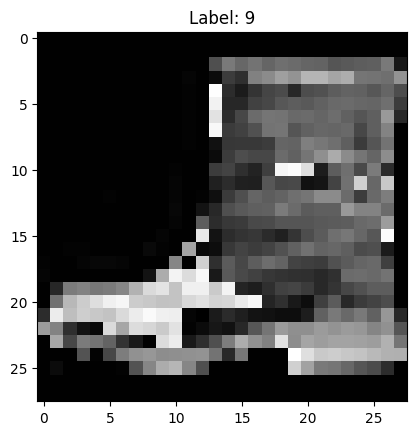

In [5]:
img=transforms.ToPILImage()(train_dataset[0][0])

plt.title('Label: {}'.format(train_dataset[0][1]))
plt.imshow(img,cmap='gray')

In [6]:
def fun_output_size(input_size, filter_size, stride_size, padding_size):
    output_size = (input_size-filter_size+2*padding_size)/stride_size + 1
    return output_size

print(fun_output_size(28, 3, 1, 1))

28.0


In [7]:
# AlexNet 모델 정의
class AlexNet_simple(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet_simple, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = None
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # print(x.size())  ###     

        # print(identity.size()) ###
        x = self.conv2(x)
        x = F.relu(x)
        # print(x.size()) ###
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # print(x.size()) ###

        # print(identity.size()) ###
        x = self.conv3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # print(x.size()) ###

        x = torch.flatten(x, 1)

        if self.fc1 is None:
            self.fc1 = nn.Linear(x.shape[1], 256).to(x.device)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

model = AlexNet_simple().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
            Conv2d-2           [-1, 64, 13, 13]          36,928
            Conv2d-3             [-1, 64, 6, 6]          36,928
            Conv2d-4             [-1, 64, 6, 6]          36,928
            Conv2d-5             [-1, 64, 6, 6]          36,928
            Linear-6                  [-1, 256]          65,792
            Linear-7                   [-1, 10]           2,570
Total params: 216,714
Trainable params: 216,714
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 0.83
Estimated Total Size (MB): 1.35
----------------------------------------------------------------


In [8]:
# 마지막 Layer: Linear activation

# 손실 함수 및 최적화 함수 설정
# loss: CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# opt: Adam
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [9]:
# 학습 및 검증
def train_epoch(model, device, train_loader, optimizer):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    return train_loss / len(train_loader.dataset)

def validate_epoch(model, device, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
    return val_loss / len(val_loader.dataset)

# 모델을 저장하는 함수
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [10]:
num_epochs=10

# 가장 좋은 모델을 기억하기 위한 변수 초기화
best_val_loss = float('inf')
best_model_path = 'best_model_P4_b_AlexNetsimple2.pth'
train_losses, val_losses = [], []

# 훈련 루프
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch(model, device, train_loader, optimizer)
    val_loss = validate_epoch(model, device, val_loader)

    # 손실 값을 기록
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # 가장 낮은 검증 손실을 가진 모델을 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_model(model, best_model_path)

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# 가장 좋은 모델을 불러옴
model.load_state_dict(torch.load(best_model_path))

Epoch: 1, Train Loss: 0.6560, Validation Loss: 0.4971
Epoch: 2, Train Loss: 0.3805, Validation Loss: 0.3604
Epoch: 3, Train Loss: 0.3148, Validation Loss: 0.3108
Epoch: 4, Train Loss: 0.2772, Validation Loss: 0.2834
Epoch: 5, Train Loss: 0.2528, Validation Loss: 0.3051
Epoch: 6, Train Loss: 0.2353, Validation Loss: 0.2563
Epoch: 7, Train Loss: 0.2181, Validation Loss: 0.2658
Epoch: 8, Train Loss: 0.2048, Validation Loss: 0.2530
Epoch: 9, Train Loss: 0.1933, Validation Loss: 0.2867
Epoch: 10, Train Loss: 0.1812, Validation Loss: 0.2475


<All keys matched successfully>

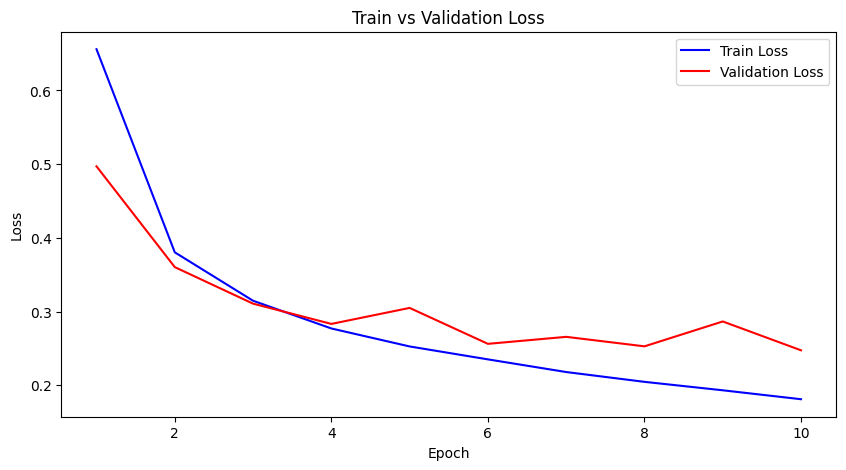

In [11]:
# Plot train/validation loss graph
plt.style.use('default')
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, 11), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [12]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [13]:
# Test
model.eval()
test_loss = 0
correct = 0
all_targets = []
all_outputs = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        all_targets.extend(target.view_as(pred))
        all_outputs.extend(output)

test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.2629, Accuracy: 9075/10000 (91%)



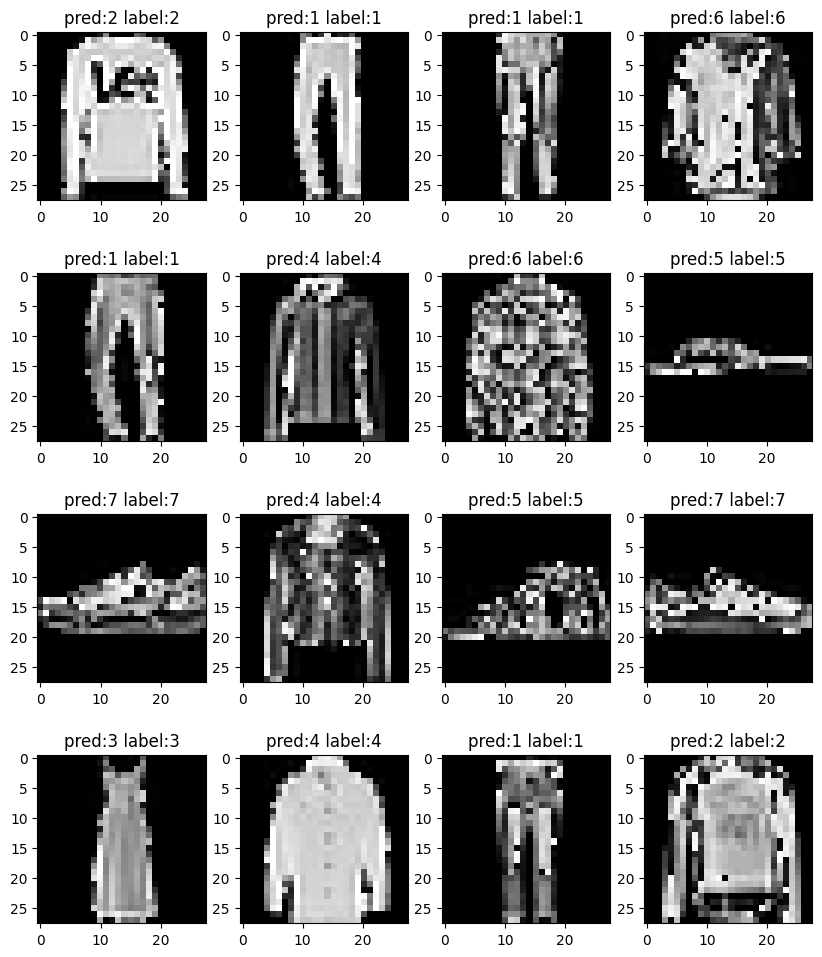

In [14]:
fig=plt.figure(figsize=(10,12))
cols=4
rows=4
for i in range(1,cols*rows+1):
    img=transforms.ToPILImage()(test_dataset[i][0])
    pred=model(test_dataset[i][0].unsqueeze(0).to(device))
    fig.add_subplot(rows,cols,i)
    plt.title('pred:{} label:{}'.format(pred.argmax().cpu().item(),test_dataset[i][1]))
    plt.imshow(img,cmap='gray')
plt.show()

In [15]:
# 리스트 형태의 텐서를 하나의 텐서로 병합
y_trues = torch.cat(all_targets).to('cpu').numpy()
y_preds = torch.stack(all_outputs).to('cpu').numpy()

# Compute the ROC-AUC for each class
roc_aucs = []
for i in range(10):
    # One vs All approach
    targets_one_vs_all = (y_trues == i)
    outputs_one_vs_all = y_preds[:, i]
    roc_aucs.append(roc_auc_score(targets_one_vs_all, outputs_one_vs_all))

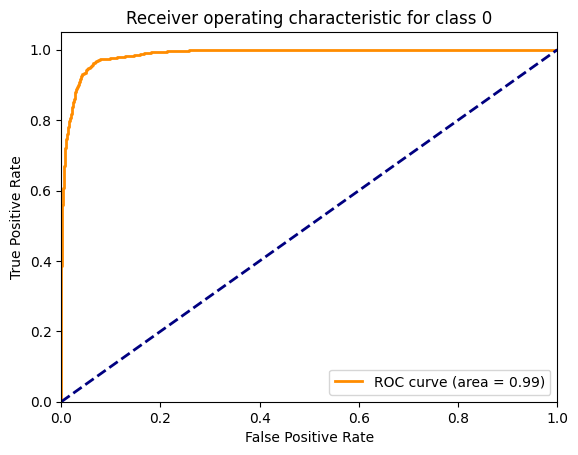

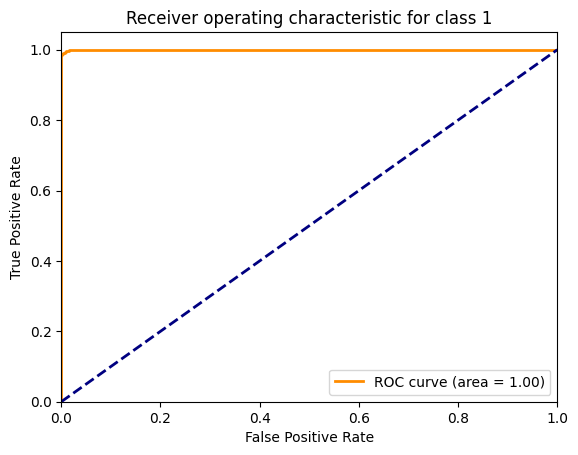

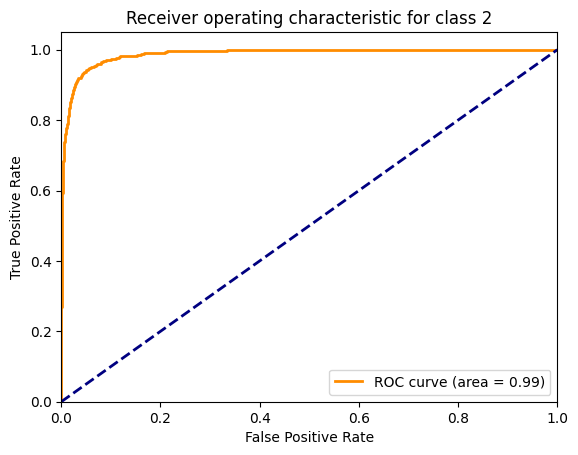

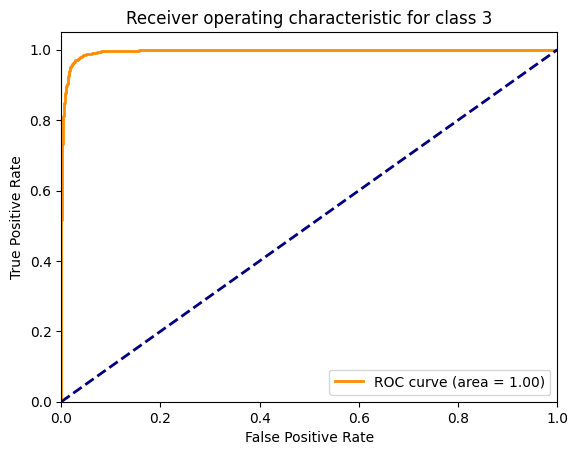

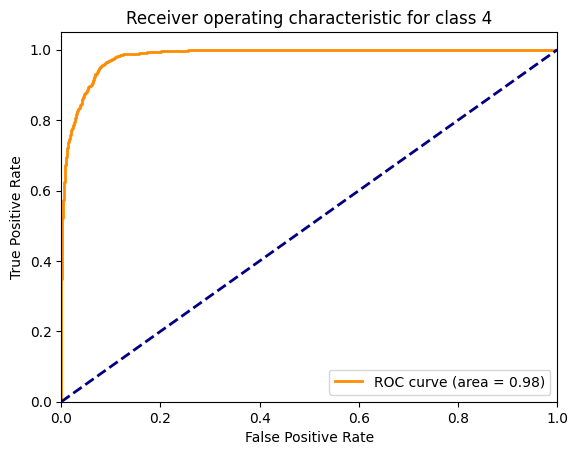

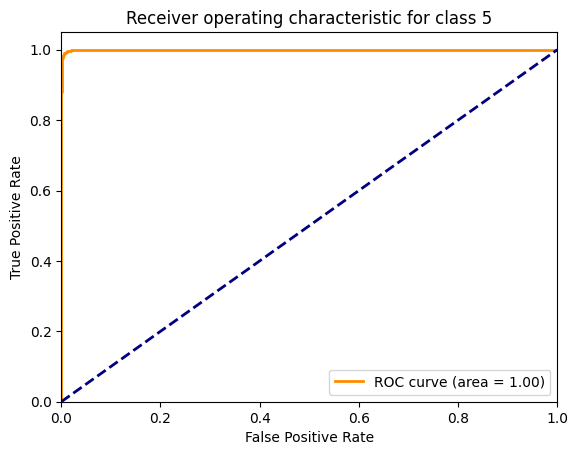

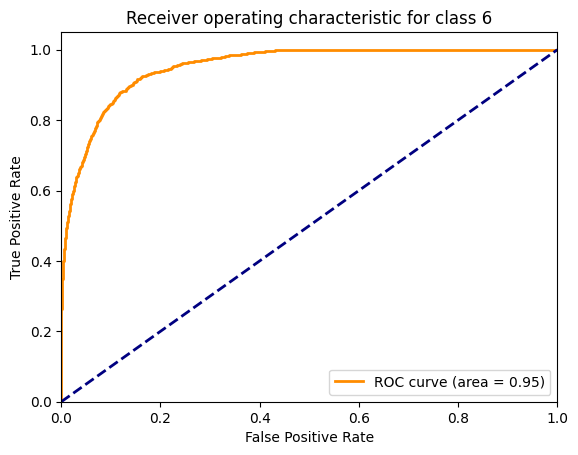

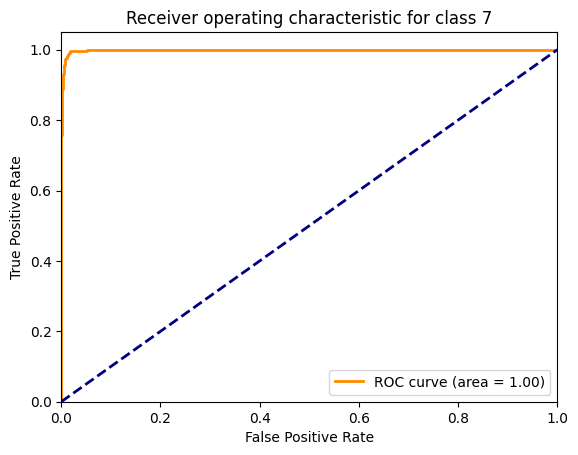

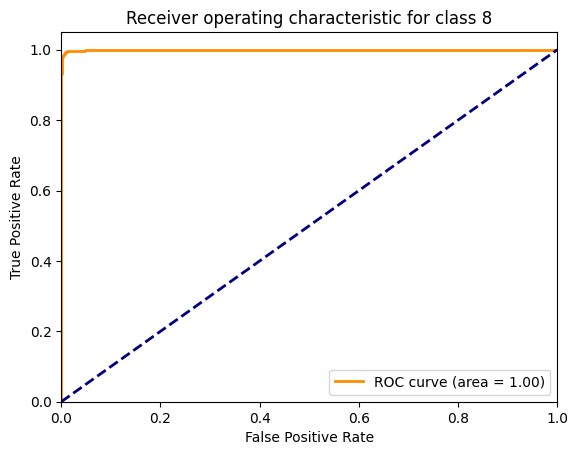

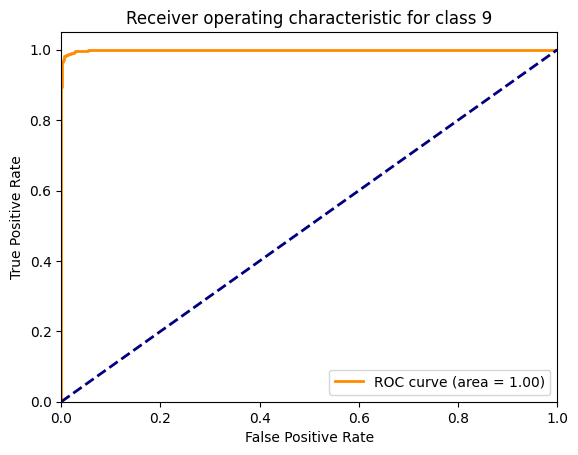

In [16]:
# 리스트 형태의 텐서를 하나의 텐서로 병합
y_trues = torch.cat(all_targets).to('cpu').numpy()
y_preds = torch.stack(all_outputs).to('cpu').numpy()

# ROC curve for each class
for i in range(10):
    # One vs All approach
    targets_one_vs_all = (y_trues == i)
    outputs_one_vs_all = y_preds[:, i]
    
    # Compute the ROC curve and AUC for this class
    fpr, tpr, _ = roc_curve(targets_one_vs_all, outputs_one_vs_all)
    roc_auc = auc(fpr, tpr)
    
    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()


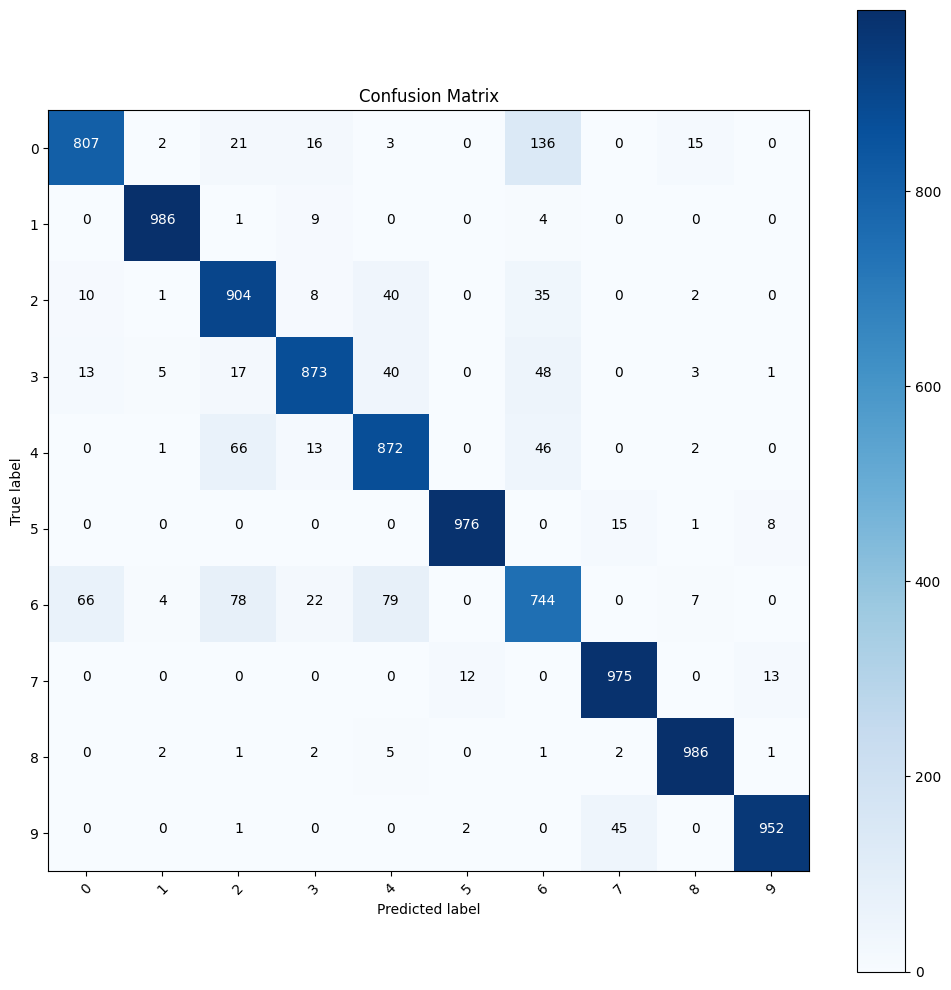

In [17]:
# 리스트 형태의 텐서를 하나의 텐서로 병합 후 NumPy 배열로 변환
y_trues = torch.cat(all_targets).to('cpu').numpy()
y_preds = torch.stack(all_outputs).to('cpu').numpy().argmax(axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_trues, y_preds)

import itertools
# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10), rotation=45)
plt.yticks(tick_marks, range(10))

# Threshold for text color contrast
thresh = conf_matrix.max() / 2.

# Iterate over the confusion matrix and add text annotations
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
from sklearn.metrics import classification_report

# 실제 레이블과 예측 레이블이 주어졌을 때, classification_report를 사용
report = classification_report(y_trues, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1000
           1       0.99      0.99      0.99      1000
           2       0.83      0.90      0.87      1000
           3       0.93      0.87      0.90      1000
           4       0.84      0.87      0.86      1000
           5       0.99      0.98      0.98      1000
           6       0.73      0.74      0.74      1000
           7       0.94      0.97      0.96      1000
           8       0.97      0.99      0.98      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

